In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import FlowCal

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage

from umap import UMAP

from hdbscan import HDBSCAN

# change working directory to where the data is
import os
os.chdir("/Users/moonbee/Cyto/Human_T_Cell_Profile/")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the cytometry data
fcs_table = FlowCal.io.FCSData('Tissue Samples_M LN.596613.fcs')
fcs_table = fcs_table.astype('<f4')  # Convert to little-endian float format
pd_df = pd.DataFrame(fcs_table)

# add colnames
pd_df.columns = fcs_table.channels

# drop the time column
pd_df.drop(columns=['Time'], inplace=True)

# view head of the data
print(pd_df.head())

           FSC-A          SSC-A       FITC-A         PE-A  Alexa Fluor 700-A  \
0  262143.000000  170898.531250  1054.500000  1688.579956       24736.140625   
1  141144.953125   68960.882812   363.660004   926.299988       15552.900391   
2  104009.835938   42376.078125    12.540000   923.939941        1407.780029   
3  100292.718750   47255.281250   126.540001   -61.359997        5387.580078   
4  107753.359375   37875.359375   198.360001   377.599976        4177.799805   

         e450-A     PE-Cy7-A   QDot 705-A   Qdot 655-A    Qdot 605-A  \
0  30471.818359  1490.339966  6727.819824  1545.479858  55426.335938   
1  12555.699219   742.219971  4297.239746   704.899963  25495.119141   
2    133.559998  1564.679932  4456.239746  8291.319336  12832.359375   
3   4061.919678   488.519989   708.079956   246.979980   9153.099609   
4   3977.119873   292.639984  1387.539917   164.299988   9253.799805   

   Alexa Fluor 647-A  
0        3071.969971  
1        1150.380005  
2       11447.370

In [3]:
# rename colnames of pd_df using biological values
colnames = list("FSC-A|SSC-A|CD14|CD103|HLADR|CD20|CD8|CD4|CD3|CD45RA|CCR7".split("|"))
pd_df.columns = colnames

# view the renamed data
print(pd_df.head())

           FSC-A          SSC-A         CD14        CD103         HLADR  \
0  262143.000000  170898.531250  1054.500000  1688.579956  24736.140625   
1  141144.953125   68960.882812   363.660004   926.299988  15552.900391   
2  104009.835938   42376.078125    12.540000   923.939941   1407.780029   
3  100292.718750   47255.281250   126.540001   -61.359997   5387.580078   
4  107753.359375   37875.359375   198.360001   377.599976   4177.799805   

           CD20          CD8          CD4          CD3        CD45RA  \
0  30471.818359  1490.339966  6727.819824  1545.479858  55426.335938   
1  12555.699219   742.219971  4297.239746   704.899963  25495.119141   
2    133.559998  1564.679932  4456.239746  8291.319336  12832.359375   
3   4061.919678   488.519989   708.079956   246.979980   9153.099609   
4   3977.119873   292.639984  1387.539917   164.299988   9253.799805   

           CCR7  
0   3071.969971  
1   1150.380005  
2  11447.370117  
3    277.200012  
4    739.530029  


In [4]:
# visualize distribution of values
print(pd_df.describe())

               FSC-A          SSC-A           CD14          CD103  \
count  124183.000000  124183.000000  124183.000000  124183.000000   
mean   125255.617188   72250.093750    1581.658569    1982.448608   
std     54591.570312   60024.390625    7829.532227    7375.416504   
min     19633.679688    9864.419922    -642.960022    -729.239990   
25%     97960.277344   40612.500000      63.840000      69.619995   
50%    114961.437500   49528.437500     214.319992     392.939972   
75%    136001.359375   67185.328125     434.339996     847.239990   
max    262143.000000  262143.000000  262143.000000  262143.000000   

               HLADR           CD20            CD8            CD4  \
count  124183.000000  124183.000000  124183.000000  124183.000000   
mean     8983.399414    4714.258301    4363.910156    8520.875000   
std     25079.185547    9957.427734   14212.581055   18448.755859   
min     -1048.410034    -221.539993    -667.879944    -787.579956   
25%      1357.290039     156.8799

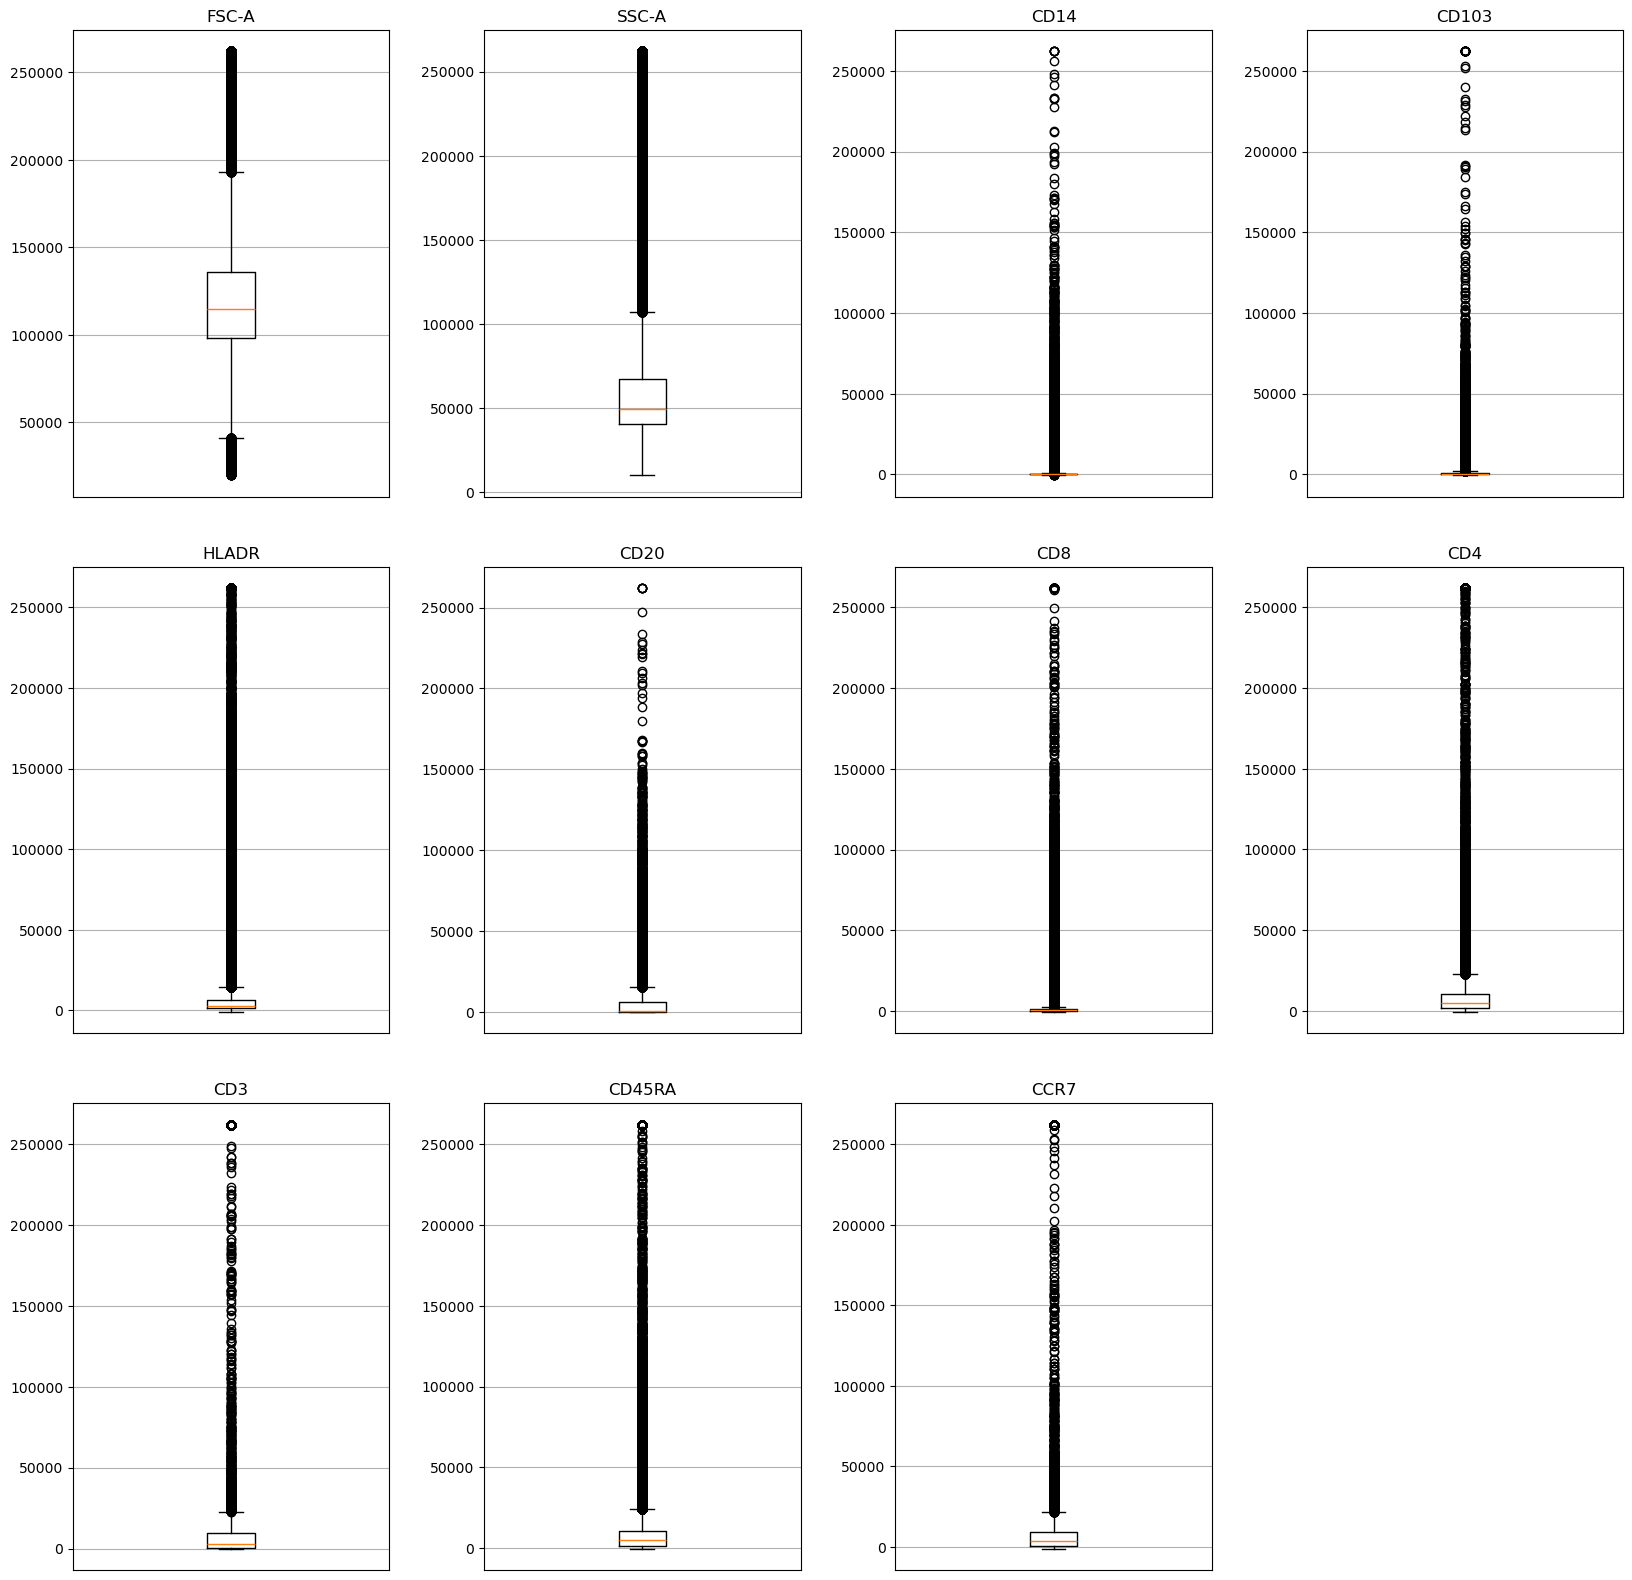

In [5]:
# merge every graph for each column into one figure
num_cols = len(pd_df.columns)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

# set the figure size
fig, axs = plt.subplots(num_rows, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.15, wspace=0.3)
axs = axs.ravel()

# plot the boxplot of raw data for each column
for i in range(num_rows * 4):
    if i < num_cols:
        axs[i].boxplot(pd_df[pd_df.columns[i]])
        axs[i].set_title(pd_df.columns[i])
        axs[i].set_xticks([])
        axs[i].grid()
    else:
        fig.delaxes(axs[i])

plt.show()

In [6]:
# count number of max values in every column
for i in pd_df.columns:
    print("Number of max values in " + i + " is " + str(pd_df[i].value_counts().max()))

Number of max values in FSC-A is 7920
Number of max values in SSC-A is 5623
Number of max values in CD14 is 272
Number of max values in CD103 is 156
Number of max values in HLADR is 455
Number of max values in CD20 is 299
Number of max values in CD8 is 178
Number of max values in CD4 is 336
Number of max values in CD3 is 248
Number of max values in CD45RA is 182
Number of max values in CCR7 is 246


In [7]:
# remove every row with max 5 values in every column
for i in pd_df.columns:
    pd_df = pd_df[pd_df[i] < pd_df[i].nlargest(5).min()]

In [8]:
# visualize updated distribution of values
print(pd_df.describe())

               FSC-A          SSC-A           CD14          CD103  \
count  114306.000000  114306.000000  114306.000000  114306.000000   
mean   115009.906250   58842.277344     559.163818    1560.584595   
std     41542.933594   37759.347656    2478.983643    4927.844727   
min     19633.679688    9864.419922    -642.960022    -729.239990   
25%     96374.960938   39934.484375      51.299999      47.199997   
50%    112679.601562   47962.078125     191.520004     342.199982   
75%    129710.021484   60304.574219     363.660004     696.199951   
max    262121.203125  262140.718750   57613.320312  184202.718750   

               HLADR           CD20            CD8            CD4  \
count  114306.000000  114306.000000  114306.000000  114306.000000   
mean     5053.746582    3348.077393    3807.597168    6255.821777   
std      9008.647461    4937.530273   12066.584961    6968.081543   
min     -1048.410034    -221.539993    -667.879944    -787.579956   
25%      1286.010010     147.3399

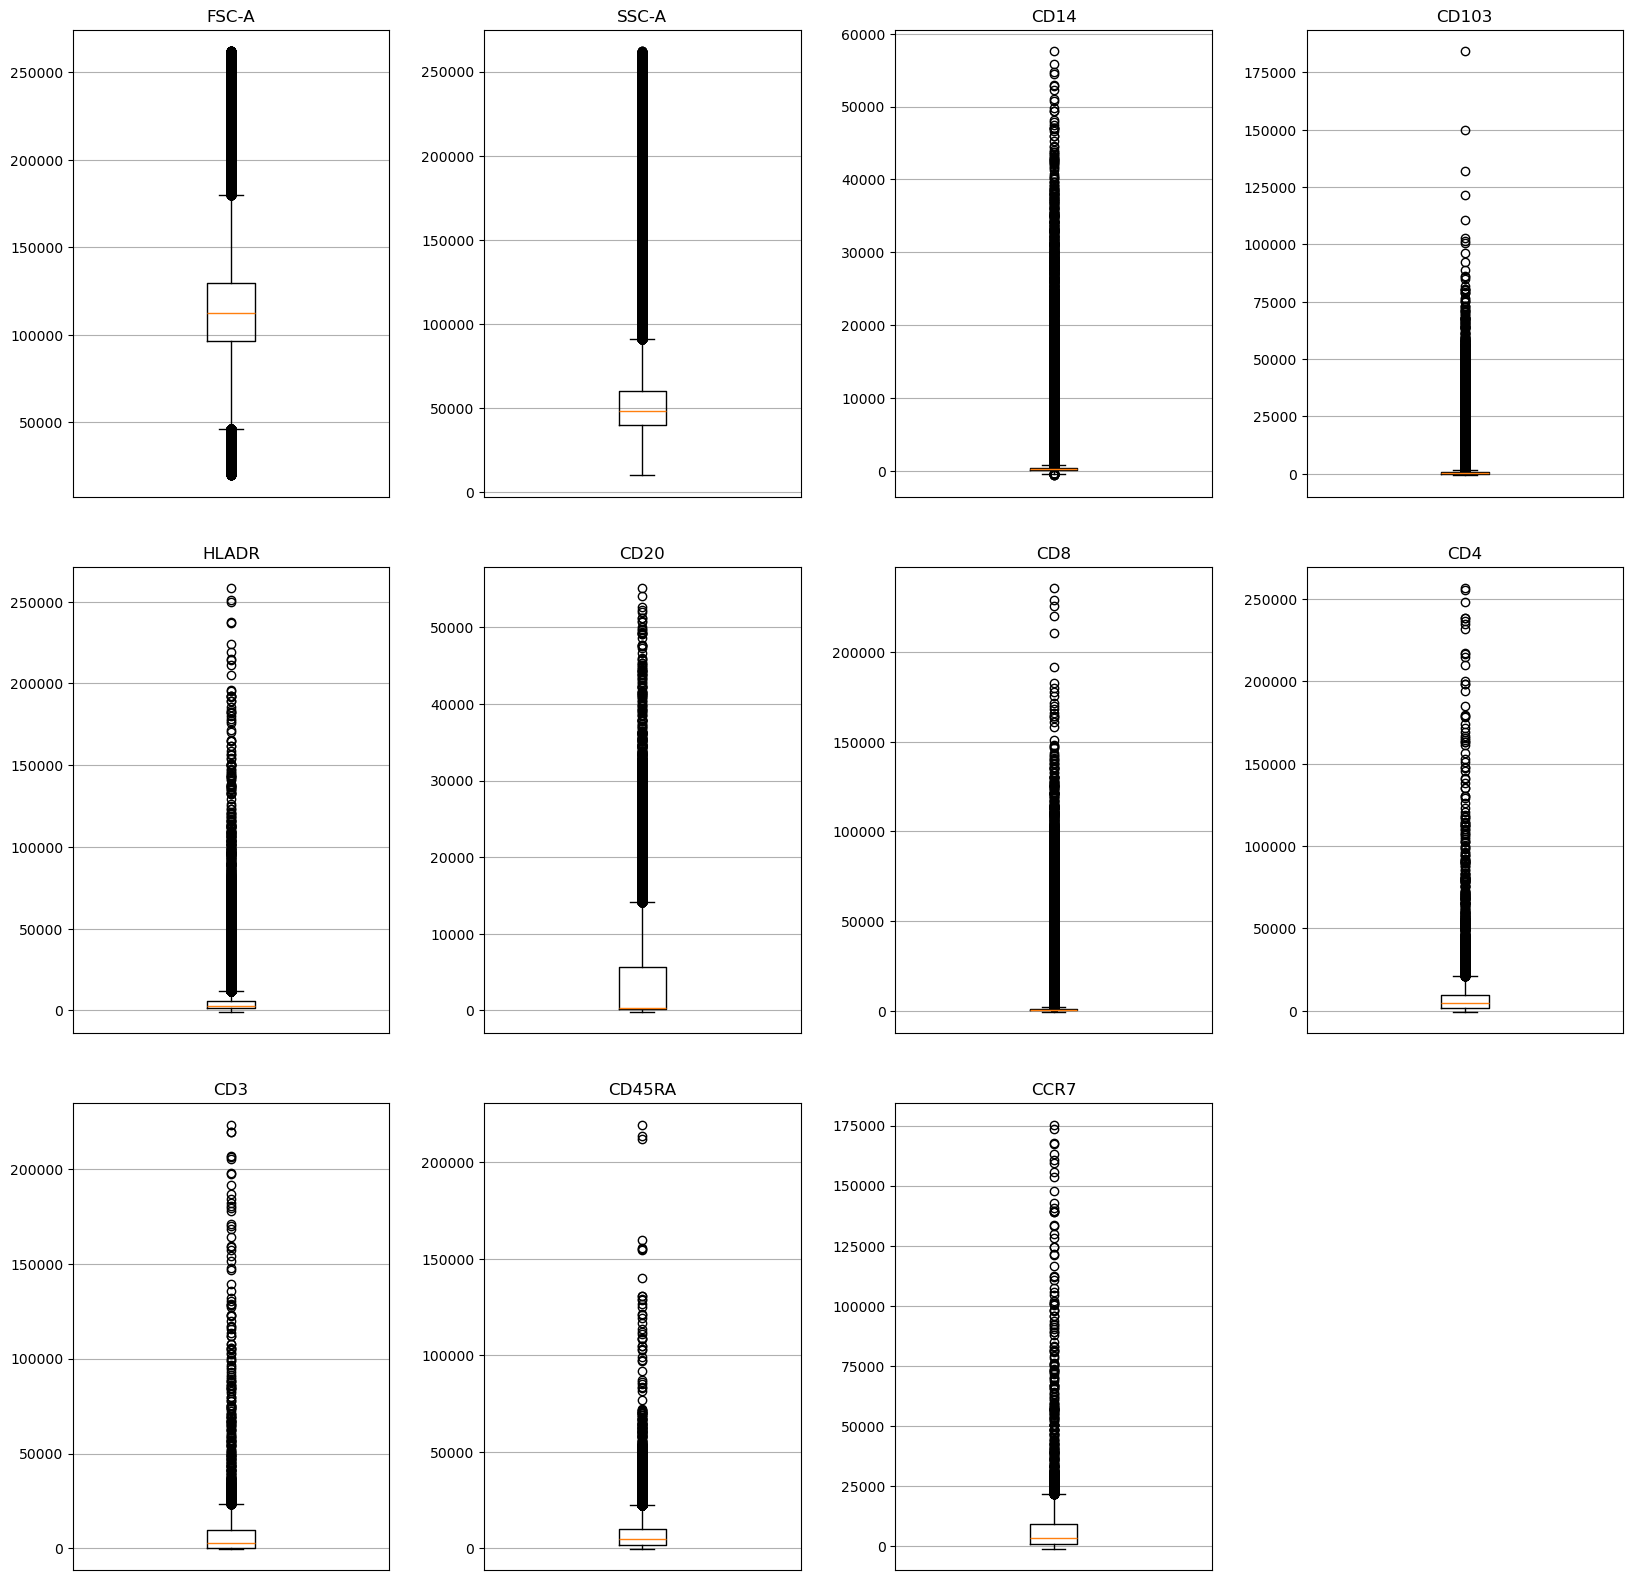

In [9]:
# merge every graph for each column into one figure
num_cols = len(pd_df.columns)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

# set the figure size
fig, axs = plt.subplots(num_rows, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.15, wspace=0.3)
axs = axs.ravel()

# plot the boxplot of data without outliers for each column
for i in range(num_rows * 4):
    if i < num_cols:
        axs[i].boxplot(pd_df[pd_df.columns[i]])
        axs[i].set_title(pd_df.columns[i])
        axs[i].set_xticks([])
        axs[i].grid()
    else:
        fig.delaxes(axs[i])

plt.show()

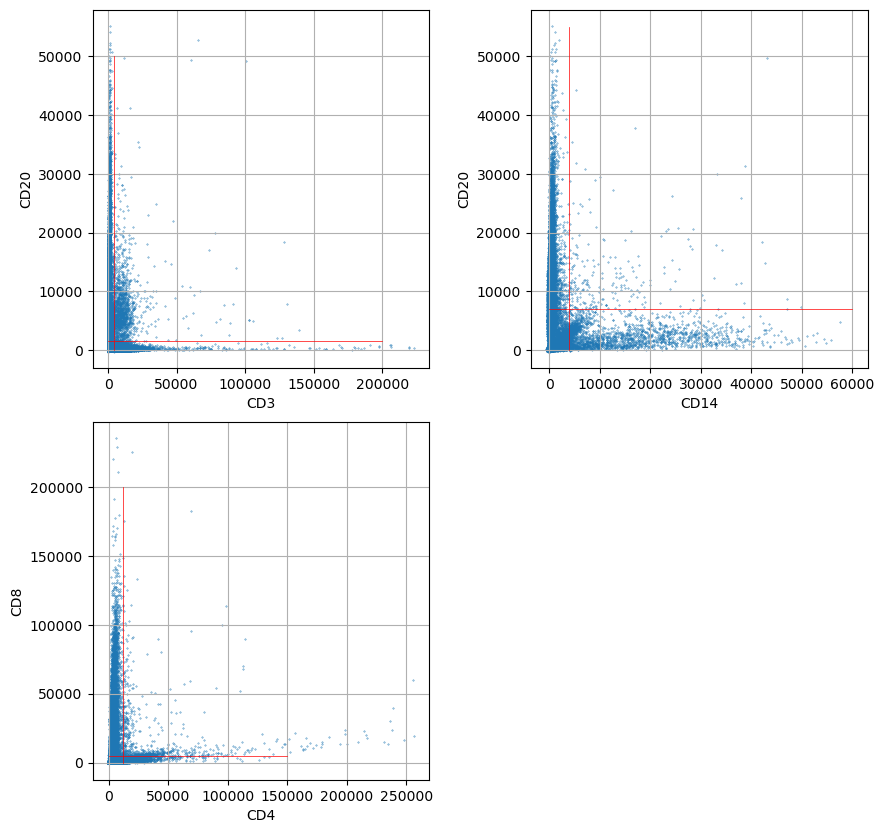

In [10]:
# plot scatterplots for identification of doublets

# merge subplots into one figure 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.15, wspace=0.3)

# First subplot
axs[0, 0].scatter(pd_df['CD3'], pd_df['CD20'], s=0.1)
axs[0, 0].set_xlabel('CD3')
axs[0, 0].set_ylabel('CD20')
axs[0, 0].plot([4000, 4000], [0, 50000], color = 'r', linewidth = 0.5)
axs[0, 0].plot([0, 200000], [1500, 1500], color = 'r', linewidth = 0.5)
axs[0, 0].grid()

# Second subplot
axs[0, 1].scatter(pd_df['CD14'], pd_df['CD20'], s=0.1)
axs[0, 1].set_xlabel('CD14')
axs[0, 1].set_ylabel('CD20')
axs[0, 1].plot([4000, 4000], [0, 55000], color = 'r', linewidth = 0.5)
axs[0, 1].plot([0, 60000], [7000, 7000], color = 'r', linewidth = 0.5)
axs[0, 1].grid()

# Third subplot
axs[1, 0].scatter(pd_df['CD4'], pd_df['CD8'], s=0.1)
axs[1, 0].set_xlabel('CD4')
axs[1, 0].set_ylabel('CD8')
axs[1, 0].plot([12000, 12000], [0, 200000], color = 'r', linewidth = 0.5)
axs[1, 0].plot([0, 150000], [5000, 5000], color = 'r', linewidth = 0.5)
axs[1, 0].grid()

# Hide the fourth subplot
axs[1, 1].axis('off')

plt.show()

In [11]:
# filter cells by the expression of double markers
pd_df = pd_df[((pd_df['CD3'] < 4000) | (pd_df['CD20'] < 1500)) & ((pd_df['CD14'] < 4000) | (pd_df['CD20'] < 7000)) & ((pd_df['CD4'] < 12000) | (pd_df['CD8'] < 5000))]

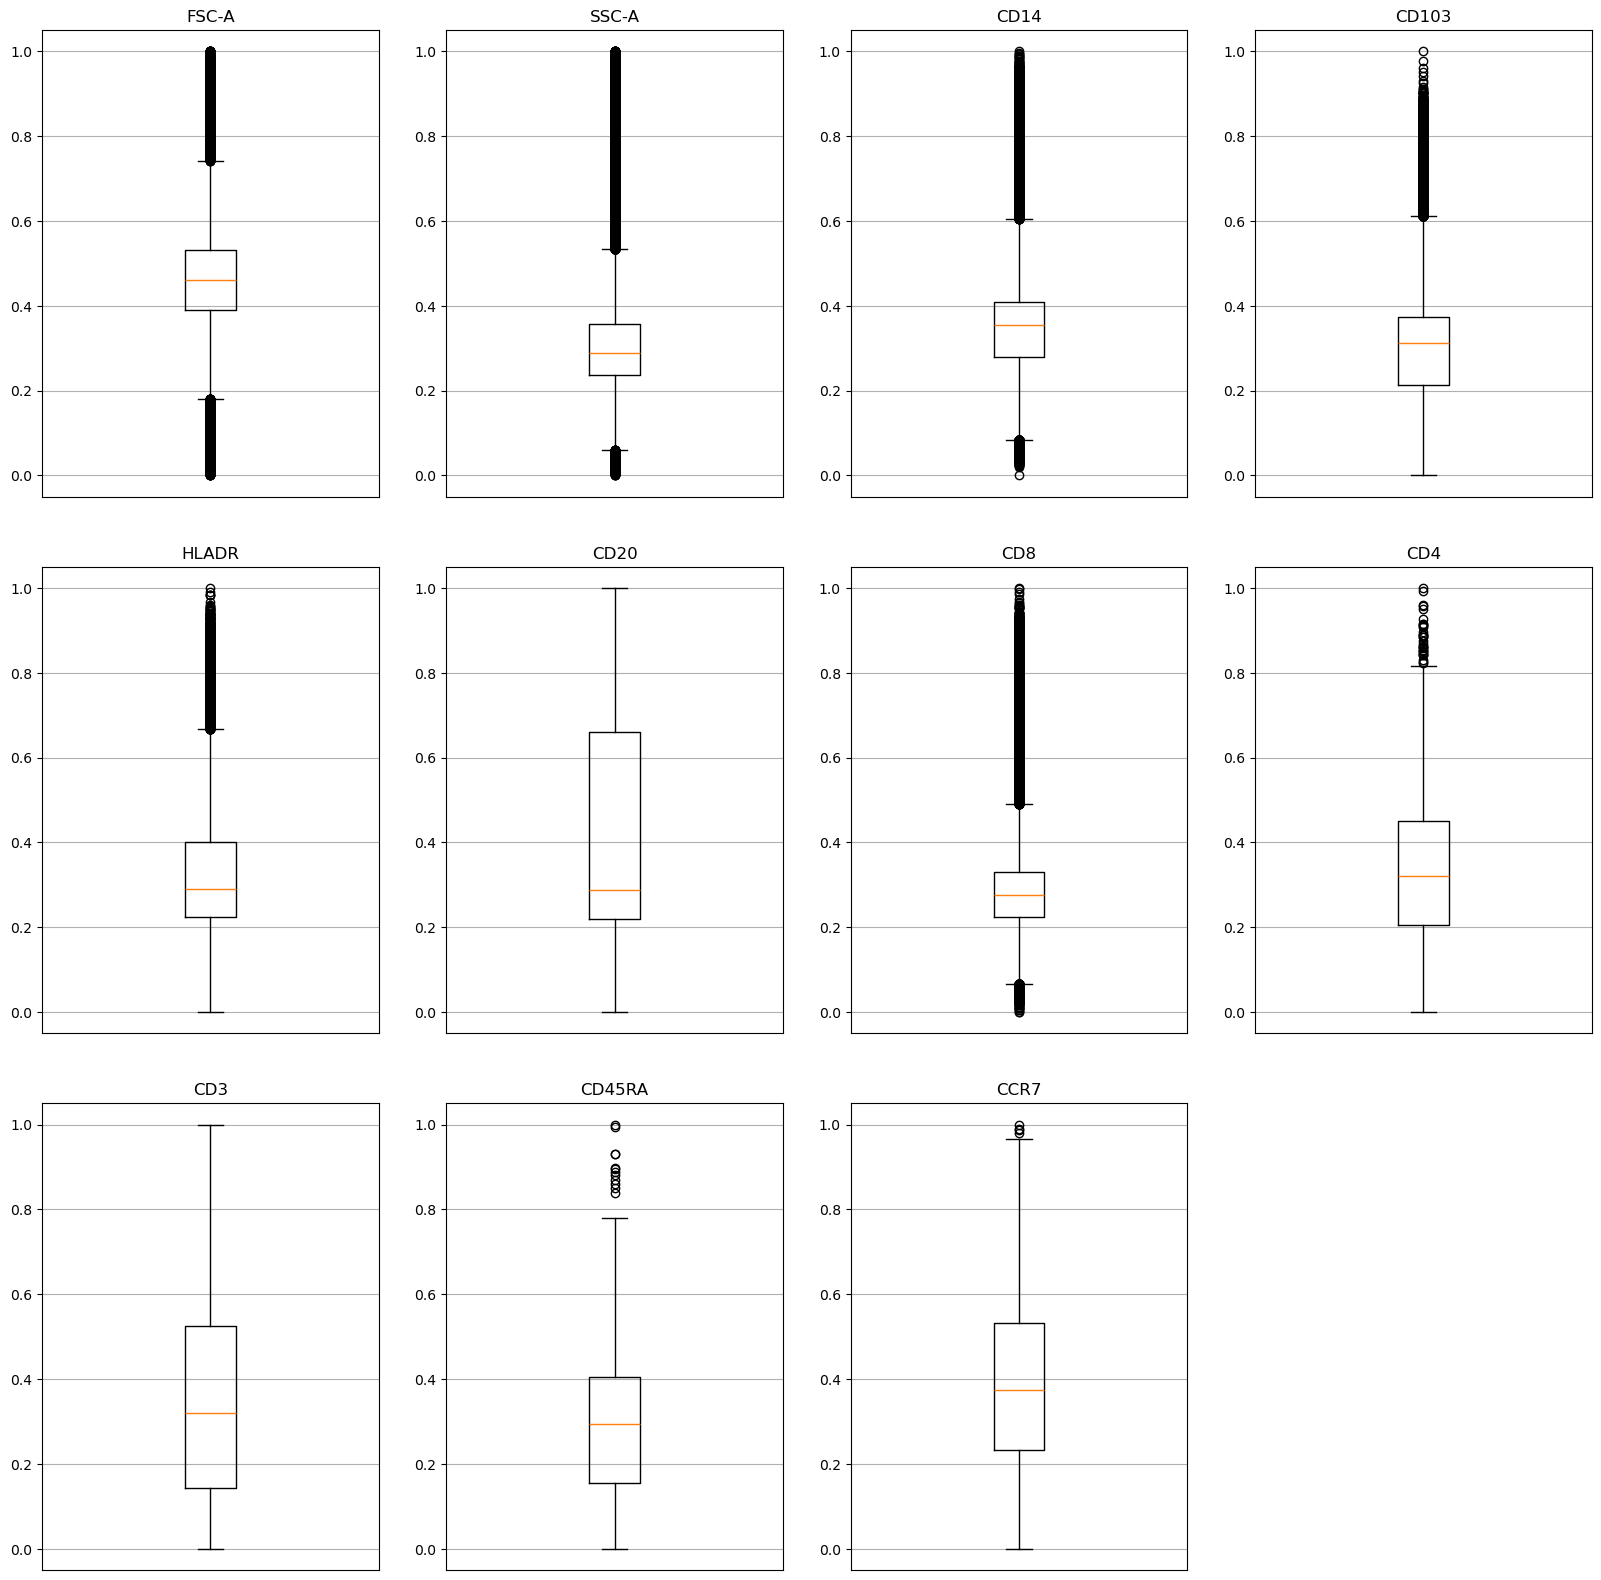

In [12]:
# Define the biexponential transformation function
def biexponential_transform(x, a, c):
    return np.sign(x) * a * np.log10(1 + np.abs(x) / c)

transformed_data = pd.DataFrame()

a = 1 # unnescessary parameter due to scaling

# define unique percentiles for columns FSC-A and SSC-A
percentiles = {
    'FSC-A': 99,
    'SSC-A': 70
}

for column in pd_df.columns:
    perc = percentiles.get(column, 30) # default percentile is 30
    c = np.percentile(np.abs(pd_df[column]), perc)
    transformed_data[column] = biexponential_transform(pd_df[column], a, c)

# perform normalization
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(transformed_data), columns=transformed_data.columns)

# merge every graph for each column into one figure
num_cols = len(scaled_data.columns)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

fig, axs = plt.subplots(num_rows, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.15, wspace=0.2)
axs = axs.ravel()

# plot the boxplot of scaled data for each column
for i in range(num_rows * 4):
    if i < num_cols:
        axs[i].boxplot(scaled_data[scaled_data.columns[i]])
        axs[i].set_title(scaled_data.columns[i])
        axs[i].set_xticks([])
        axs[i].grid()
    else:
        fig.delaxes(axs[i]) 
plt.show()

In [13]:
# perform dimensionality reduction
umap = UMAP(n_components=2, n_neighbors=100, min_dist=0.3, random_state=42)
reduced_data_UMAP = umap.fit_transform(scaled_data)

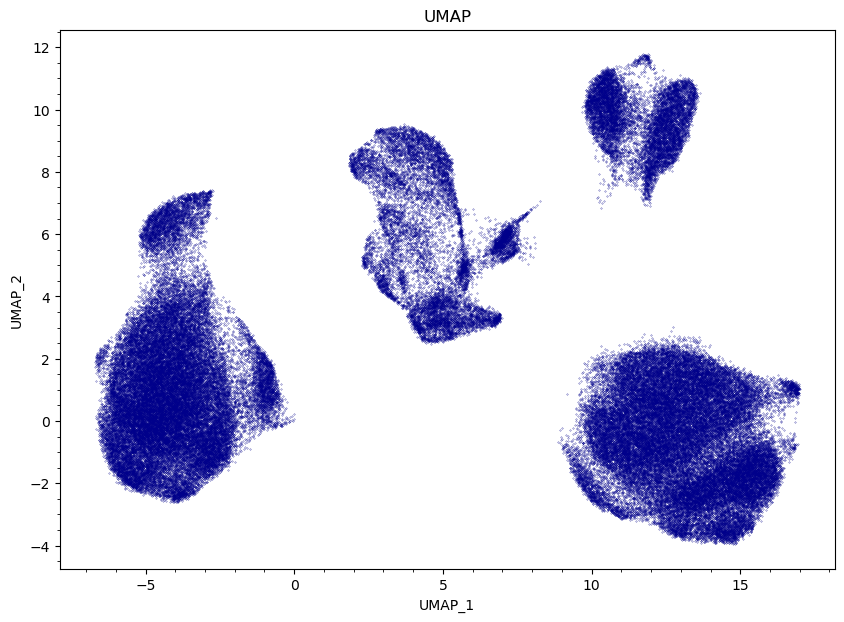

In [14]:
# plot the reduced data
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data_UMAP[:, 0], reduced_data_UMAP[:, 1], s=0.05, c='darkblue')
plt.title('UMAP')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.minorticks_on()
plt.show()

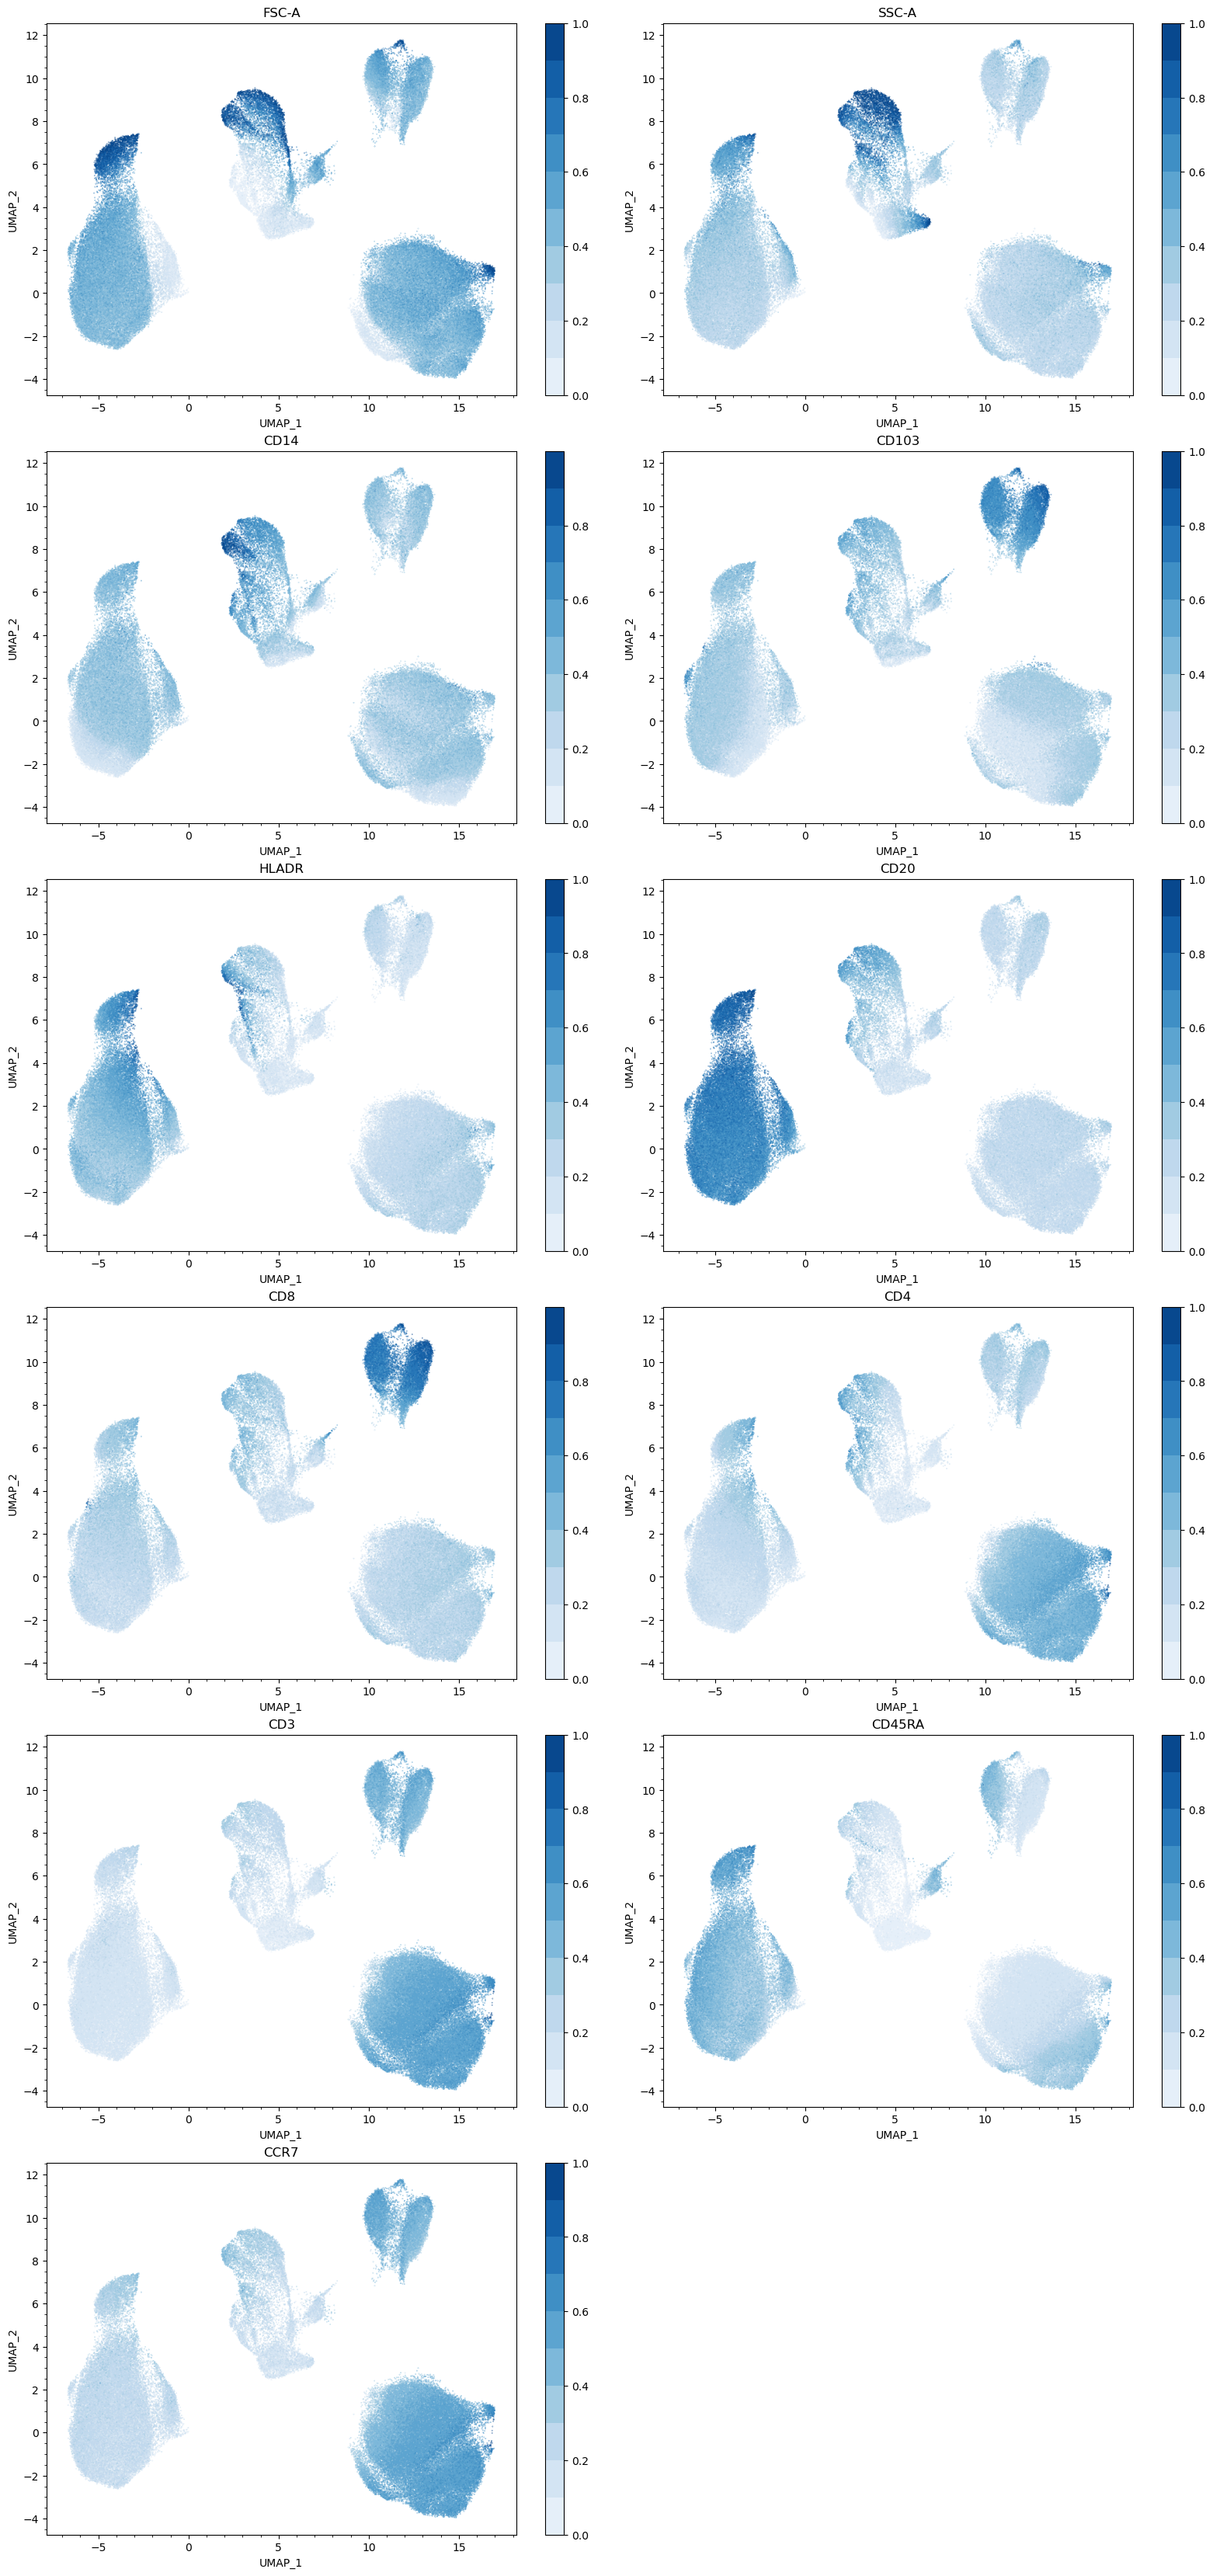

In [15]:
# set color map
sequential_colors = sns.color_palette("Blues", 10)
cmap = ListedColormap(sequential_colors)

# determine the number of rows and columns for the subplot grid
num_cols = len(scaled_data.columns)
num_rows = (num_cols // 2) + (num_cols % 2 > 0)

# create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 7 * num_rows))
fig.subplots_adjust(hspace=0.15, wspace=0.05)

# flatten the axis array for easy indexing
axs = axs.ravel()

# loop over each column and create a UMAP scatter plot
for i, column in enumerate(scaled_data.columns):
    ax = axs[i]
    scatter = ax.scatter(reduced_data_UMAP[:, 0], reduced_data_UMAP[:, 1], s=0.05, c=scaled_data[column], cmap=cmap)
    ax.set_title(column)
    ax.set_xlabel("UMAP_1")
    ax.set_ylabel("UMAP_2")
    ax.minorticks_on()
    fig.colorbar(scatter, ax=ax)

# remove any extra axes
for j in range(i + 1, num_rows * 2):
    fig.delaxes(axs[j])

plt.show()


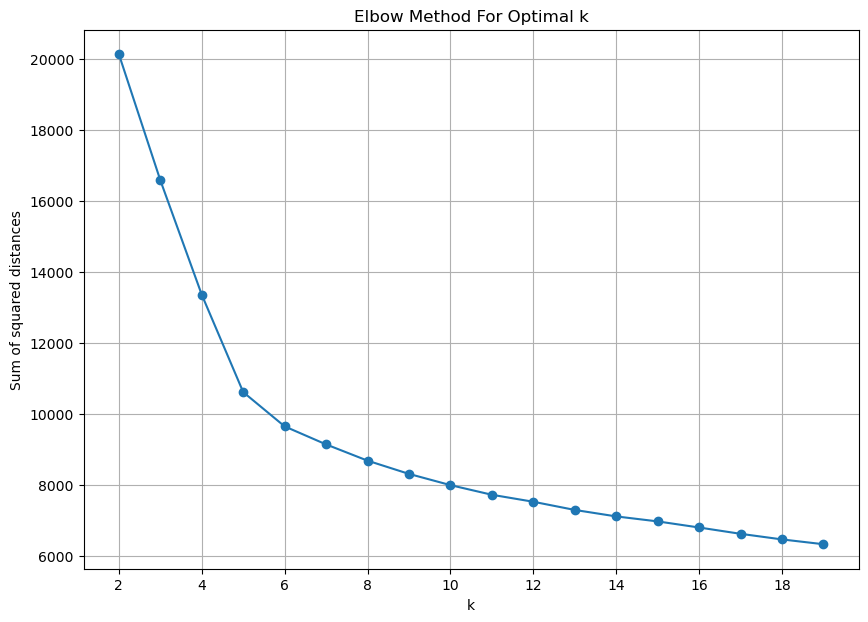

In [16]:
# perform elbow method to find the optimal number of clusters
sum_of_squared_distances = []
K = range(2, 20)
for k in K:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km = km.fit(scaled_data)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 7))
plt.plot(K, sum_of_squared_distances, 'o-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(2, 20, 2))
plt.grid()
plt.show()

NameError: name 'cmap_KMeans' is not defined

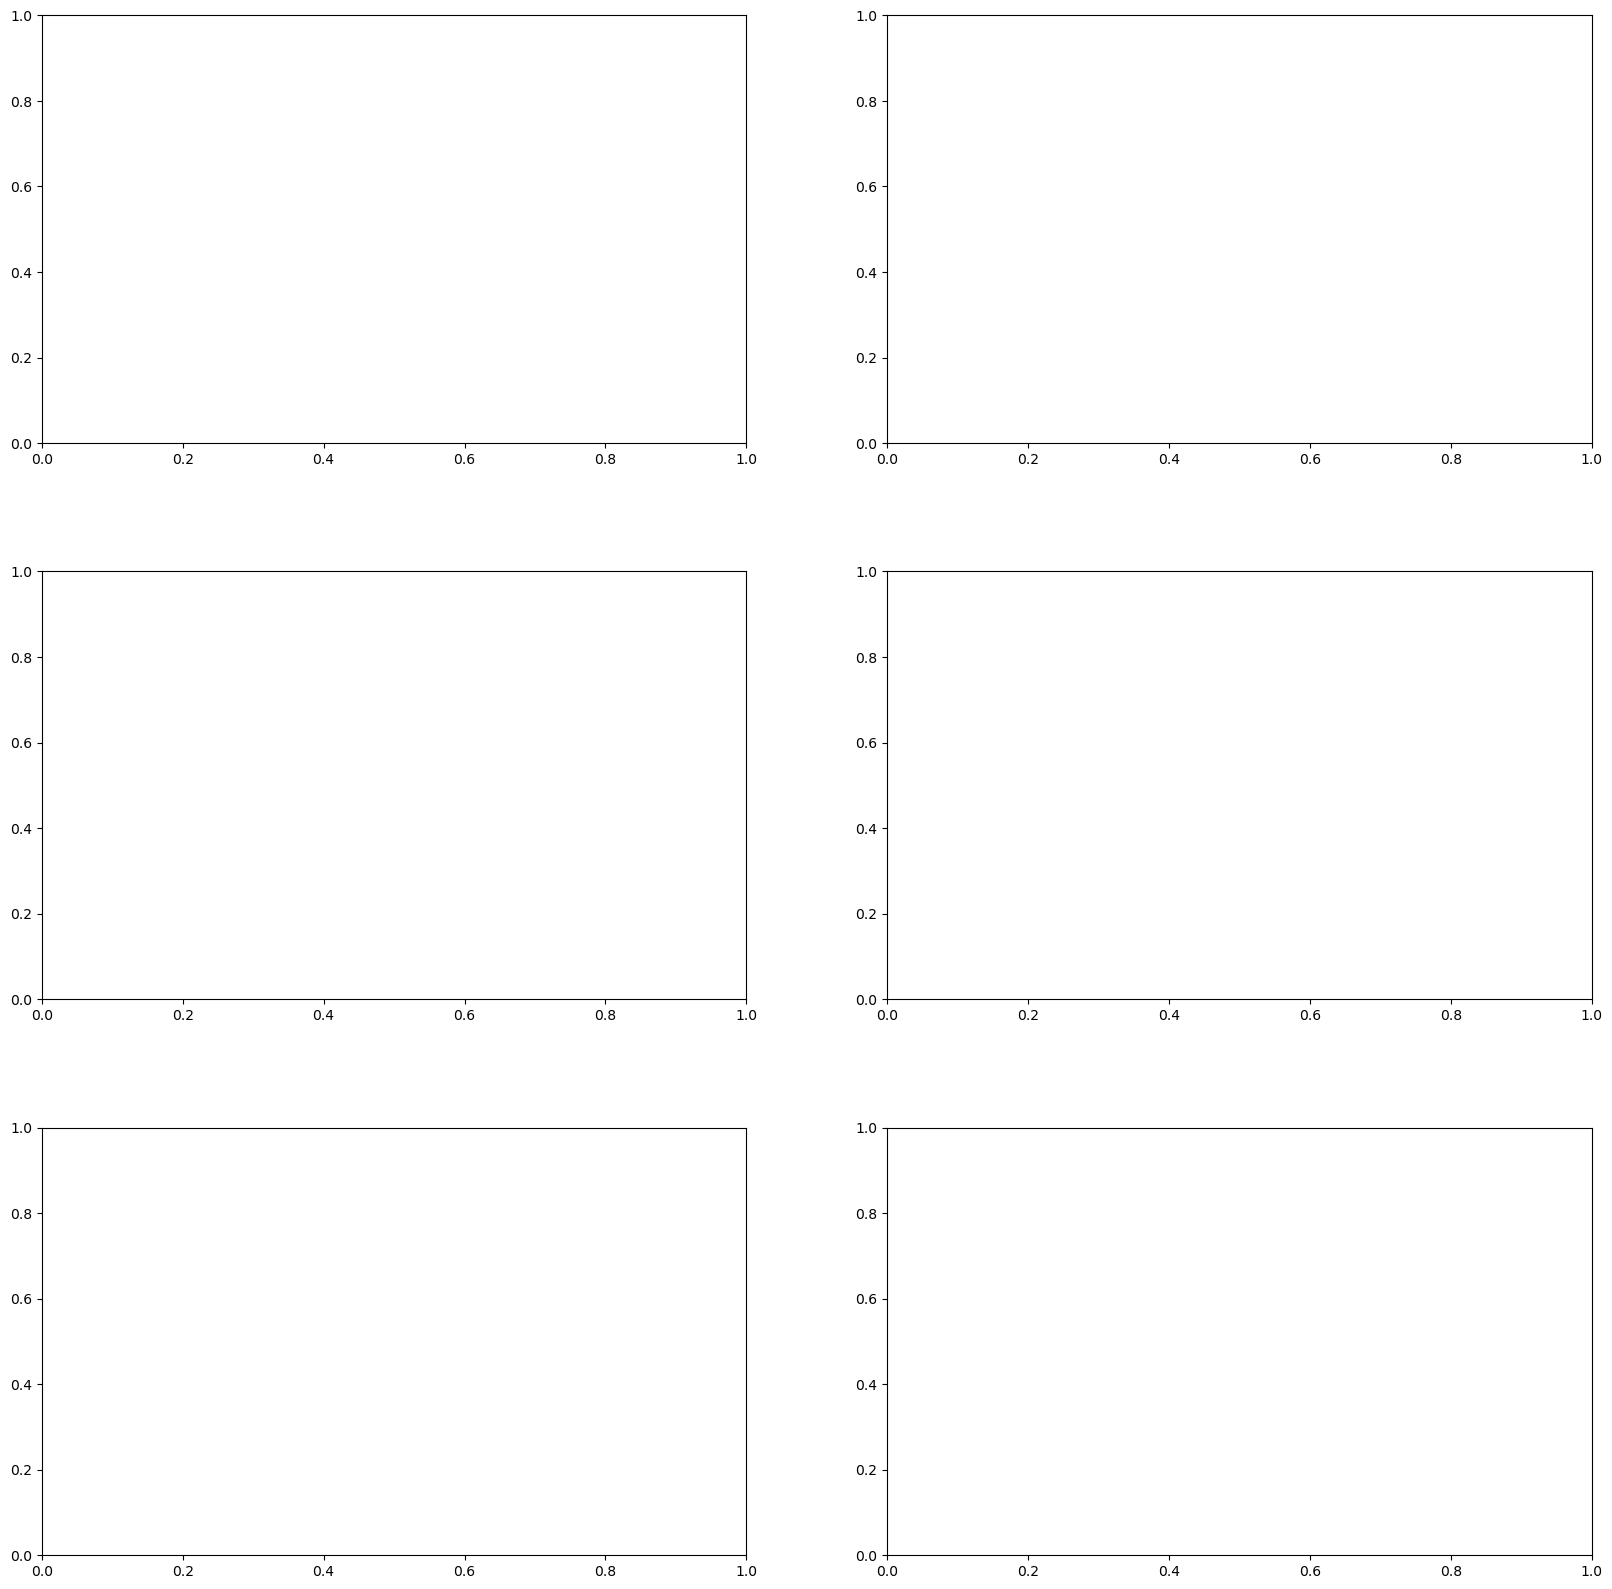

In [17]:
# define the parameter grid
n_clusters_grid = [5, 6, 7, 8, 9, 10]

# merge subplots into one figure 3x2
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# perform the grid search
for n_clusters in n_clusters_grid:
    # define the model
    model = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    # fit the model
    model.fit(scaled_data)
    # assign a cluster to each example
    yhat = model.predict(scaled_data)
    # retrieve unique clusters
    clusters = np.unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = np.where(yhat == cluster)
        # create scatter of these samples
        axs[(n_clusters - 5) // 2, (n_clusters - 5) % 2].scatter(reduced_data_UMAP[row_ix, 0], reduced_data_UMAP[row_ix, 1], s=0.05, cmap=cmap_KMeans)
    # show the plot
    axs[(n_clusters - 5) // 2, (n_clusters - 5) % 2].set_title('k = ' + str(n_clusters))
    axs[(n_clusters - 5) // 2, (n_clusters - 5) % 2].set_xlabel("UMAP_1")
    axs[(n_clusters - 5) // 2, (n_clusters - 5) % 2].set_ylabel("UMAP_2")
    axs[(n_clusters - 5) // 2, (n_clusters - 5) % 2].minorticks_on()

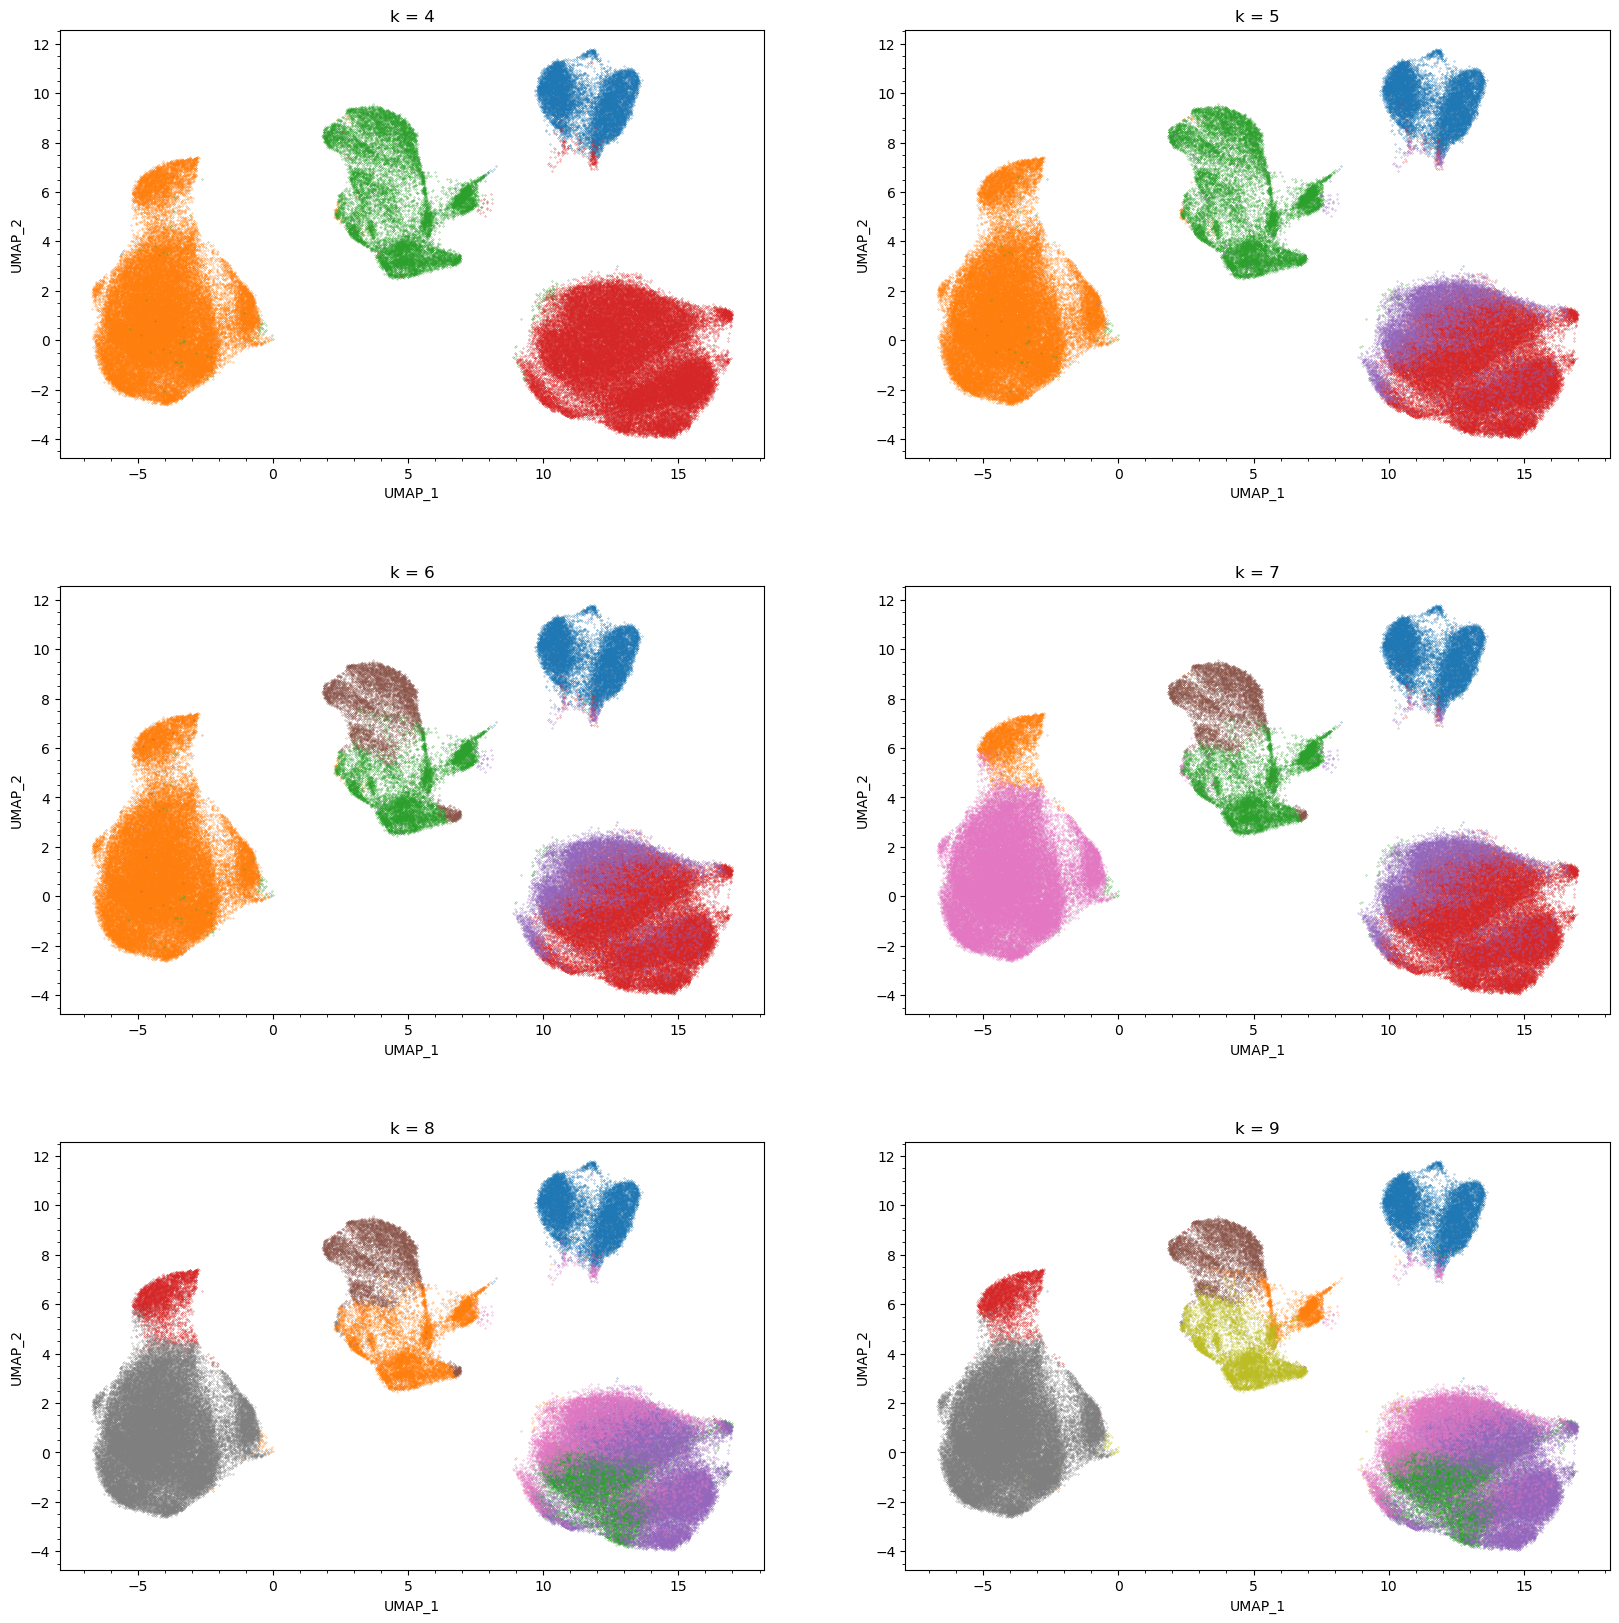

In [ ]:
# define the parameter grid
n_components_grid = [4, 5, 6, 7, 8, 9]

# merge subplots into one figure 3x2
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# perform the grid search
for n_components in n_components_grid:
    # define the model
    gmm = GaussianMixture(n_components=n_components, covariance_type='tied', tol = 1e-5, random_state=42)
    # fit the model
    gmm.fit(scaled_data)
    # assign a cluster to each example
    yhat = gmm.predict(scaled_data)
    # retrieve unique clusters
    clusters = np.unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = np.where(yhat == cluster)
        # create scatter of these samples
        axs[(n_components - 4) // 2, (n_components - 4) % 2].scatter(reduced_data_UMAP[row_ix, 0], reduced_data_UMAP[row_ix, 1], s=0.05, cmap=cmap_KMeans)
    # show the plot
    axs[(n_components - 4) // 2, (n_components - 4) % 2].set_title('k = ' + str(n_components))
    axs[(n_components - 4) // 2, (n_components - 4) % 2].set_xlabel("UMAP_1")
    axs[(n_components - 4) // 2, (n_components - 4) % 2].set_ylabel("UMAP_2")
    axs[(n_components - 4) // 2, (n_components - 4) % 2].minorticks_on()

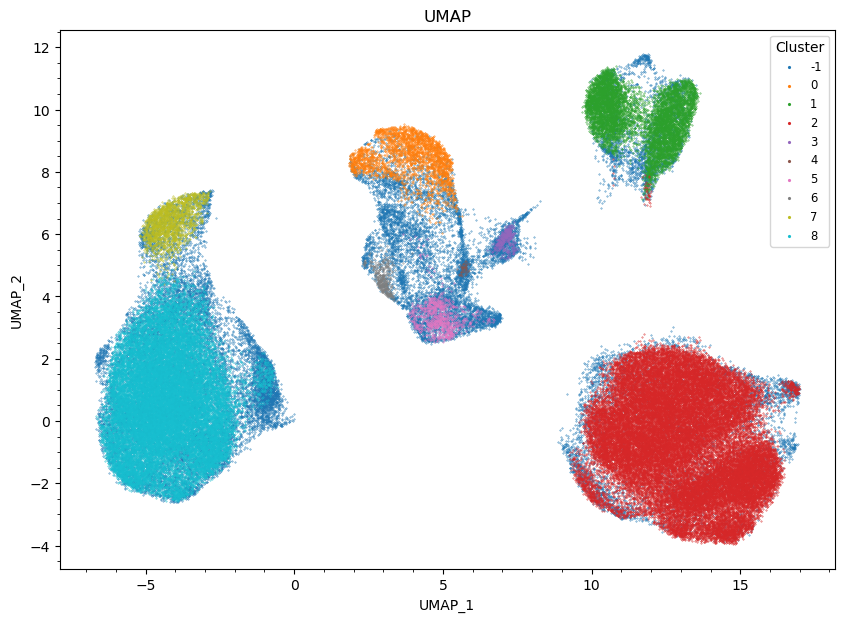

In [ ]:
# create an HDBSCAN model
hdb = HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)

# fit the model to your data
hdb.fit(scaled_data)

# plot the UMAP with cluster labels
plt.figure(figsize=(10, 7))

# get unique labels
unique_labels = np.unique(hdb.labels_)

# plot each cluster with a different color and label
for label in unique_labels:
    mask = hdb.labels_ == label
    plt.scatter(reduced_data_UMAP[mask, 0], reduced_data_UMAP[mask, 1], s=0.1, label=label)

plt.title('UMAP')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.minorticks_on()

# add a legend
plt.legend(title='Cluster', loc='upper right', fontsize='small', markerscale=4)

plt.show()


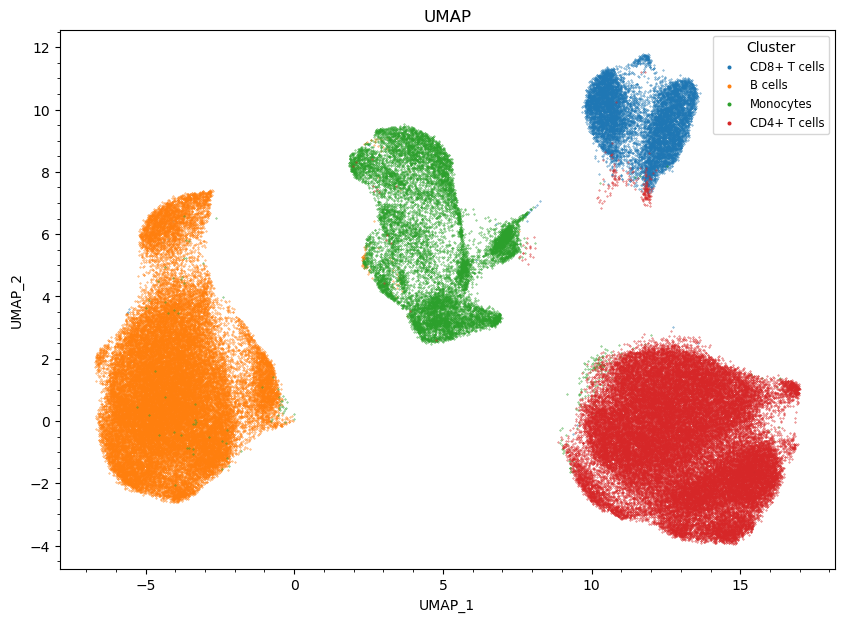

In [ ]:
# visualize the best clustering model

# define the final model
gmm = GaussianMixture(n_components=4, covariance_type='tied', tol = 1e-5, random_state=42)
# fit the model
gmm.fit(scaled_data)
# assign a cluster to each example
yhat = gmm.predict(scaled_data)

# create a dictionary that maps cluster numbers to cell types
cluster_names = {0: "CD8+ T cells", 1: "B cells", 2: "Monocytes", 3: "CD4+ T cells"}

# assign original dataframes with cluster labels
scaled_data['Cluster'] = yhat
scaled_data['Cluster'] = scaled_data['Cluster'].map(cluster_names)

# visualize UMAP with cluster labels
plt.figure(figsize=(10, 7))

# get unique labels
unique_labels = np.unique(yhat)

# plot each cluster with a different color and label
for label in unique_labels:
    mask = yhat == label
    plt.scatter(reduced_data_UMAP[mask, 0], reduced_data_UMAP[mask, 1], s=0.1, label=cluster_names[label])

plt.title('UMAP')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.minorticks_on()

# add a legend
plt.legend(title='Cluster', loc='upper right', fontsize='small', markerscale=6)

plt.show()

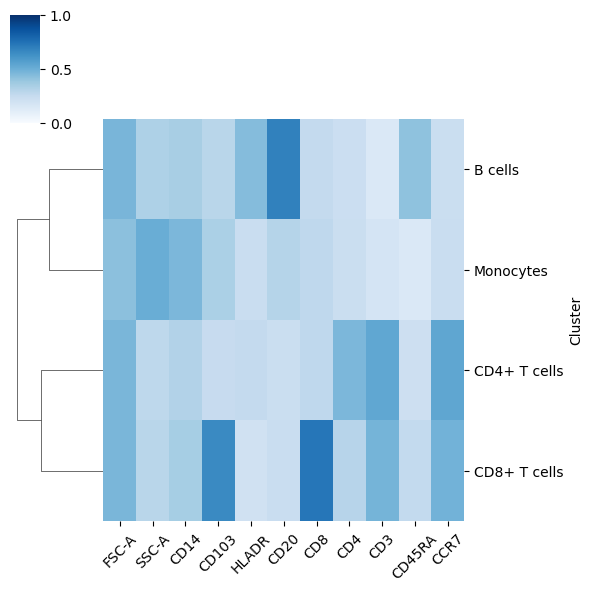

In [ ]:
# sample 10% of the data for faster processing
sampled_data = scaled_data.sample(frac=0.1)  

# get the mean of each cluster by each column
cluster_means = sampled_data.groupby('Cluster').mean()

# perform hierarchical clustering for clusters by mean expression
Z = linkage(cluster_means, 'ward')

# create a clustermap with seaborn
g = sns.clustermap(cluster_means, row_linkage=Z, cmap="Blues", col_cluster=False, yticklabels=True, figsize=(6, 6), vmin=0, vmax=1)

# Rotate the row and column labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45) 
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()